$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 4: Classification with LDA and Logistic Regression

*Yinzhi Deng* 

*CSU ID: 830888654*

## Overview

Compare LDA and linear and nonlinear logistic regression applied to two data sets.

## Required Code

Download [nn2.tar](http://www.cs.colostate.edu/~anderson/cs480/notebooks/nn2.tar) and extract its contents, which are

* `neuralnetworks.py`
* `scaledconjugategradient.py`
* `mlutils.py`

as discussed in lecture. 

Write the following functions that train and evaluate LDA and neural network logistic regression models.

* `model = trainLDA(X,T,parameters)`
* `percentCorrect = evaluateLDA(model,X,T)`
* `model = trainNN(X,T,parameters)`
* `percentCorrect = evaluateNN(model,X,T)`
The `parameters` argument for `trainNN` is a list of the hidden layers structure and the number of SCG iterations, as in the previous assignment. The value of the `parameters` argument for `trainLDA` is not used.

Use the `trainValidateTestKFoldsClassification` function in `mlutils.py` to apply the above functions. 

The `NeuralNetworkClassifier` class in the above `neuralnetworks.py` file allows you to specify 0 hidden units.  This creates a neural network with just the output layer designed to do classification.  In other words, specify 0 hidden units to apply linear logistic regression.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import neuralnetworks as nn
import mlutils as ml
%matplotlib inline

In [2]:
import numpy as np
import sys # for sys.float_info.epsilon

######################################################################
### class QDA
######################################################################

class LDA(object):
    
    def __init__(self):
        # Define all instance variables here. Not necessary
        self.means = None
        self.stds = None
        self.mu = None
        self.sigma = None
        self.sigmaInv = None
        self.prior = None
        self.determinant = None
        self.discriminantConstant = None

    def train(self,X,T):
        self.classes = np.unique(T)
        self.means, self.stds = np.mean(X,0), np.std(X,0)
        Xs = (X - self.means) / self.stds
        self.mu = []
        self.sigma = []
        self.sigmaInv = []
        self.determinant = []
        self.prior = []
        nSamples = X.shape[0]
        for k in self.classes:
            rowsThisClass = (T == k).reshape((-1))
            self.mu.append( np.mean(Xs[rowsThisClass,:],0).reshape((-1,1)) )
            self.sigma.append( np.cov(Xs[rowsThisClass,:],rowvar=0) )
            if self.sigma[-1].size == 1:
                self.sigma[-1] = self.sigma[-1].reshape((1,1))
            det = np.linalg.det(self.sigma[-1])
            if det == 0:
                det = sys.float_info.epsilon
            self.determinant.append( det )
            self.sigmaInv.append( np.linalg.pinv(self.sigma[-1]) )    # pinv in case Sigma is singular
            self.prior.append( np.sum(rowsThisClass) / float(nSamples) )
        self._finishTrain()

    def _finishTrain(self):
        self.sigmaMean = np.sum(np.stack(self.sigma) * np.array(self.prior)[:,np.newaxis,np.newaxis], axis=0)
        self.sigmaMeanInv = np.linalg.pinv(self.sigmaMean)
        # print(self.sigma)
        # print(self.sigmaMean)
        self.discriminantConstant = []
        self.discriminantCoefficient = []
        for ki in range(len(self.classes)):
            sigmaMu = np.dot(self.sigmaMeanInv, self.mu[ki])
            self.discriminantConstant.append( -0.5 * np.dot(self.mu[ki].T, sigmaMu) )
            self.discriminantCoefficient.append( sigmaMu )
    
    def _discriminantFunction(self,Xs):
        D = Xs.shape[0]
        nSamples = Xs.shape[0]
        discriminants = np.zeros((nSamples, len(self.classes)))
        for ki in range(len(self.classes)):
            discriminants[:,ki:ki+1] = self.discriminantConstant[ki] + \
                                       np.dot(Xs, self.discriminantCoefficient[ki])
        probabilities = np.exp( discriminants - 0.5*D*np.log(2*np.pi) - 0.5*np.log(self.determinant[ki]) \
                               - 0.5*np.sum(np.dot(Xs,self.sigmaMeanInv) * Xs, axis=1).reshape((-1,1)))
        return discriminants, probabilities
    def use(self,X):
        nSamples = X.shape[0]
        Xs = (X - self.means) / self.stds
        discriminants,probabilities = self._discriminantFunction(Xs)
        predictedClass = self.classes[np.argmax( discriminants, axis=1 )]
        predictedClass = predictedClass.reshape((-1,1))
        D = X.shape[1]
        return predictedClass,probabilities,discriminants
        
    def __repr__(self):
        if self.mu is None:
            return 'QDA not trained.'
        else:
            return 'QDA trained for classes {}'.format(self.classes)

### 1. LDA Part

In [3]:
def discLDA(X, means,stds, mu, Sigma, prior):
    X = (X-means)/stds
    if Sigma.size == 1:
        Sigma = np.asarray(Sigma).reshape((1,1))
    det = np.linalg.det(Sigma)        
    # if det == 0:
    #    raise np.linalg.LinAlgError('discQDA(): Singular covariance matrix')
    SigmaInv = np.linalg.pinv(Sigma)     # pinv in case Sigma is singular
    mu = mu.reshape((-1,1)) # make mu a column vector
    # pdb.set_trace()
    return np.dot(np.dot(X,SigmaInv), mu) - 0.5 * np.dot(np.dot(mu.T,SigmaInv), mu) + np.log(prior)

In [4]:
def trainLDA(X,T,parameters = None):
    lda = LDA()
    lda.mu = parameters
    lda.train(X,T)
    return lda

In [5]:
def evaluateLDA(model,X,T):
    pClass,prob,disc = model.use(X)
    #percentCorrect = np.sum(T==pClass) / float(T.shape[0]) * 100
    return np.sum(T==pClass) / float(T.shape[0]) * 100

### 2. Linear Regression Part

In [58]:
def makeIndicatorVars(T):
    # Make sure T is two-dimensiona. Should be nSamples x 1.
    if T.ndim == 1:
        T = T.reshape((-1,1))    
    return (T == np.unique(T)).astype(int)

In [59]:
# import pdb
def g(X,w):
    fs = np.exp(np.dot(X, w))  # N x K-1
    denom = (1 + np.sum(fs,axis=1)).reshape((-1,1))
    # pdb.set_trace()
    gs = fs / denom
    # print(gs[:10,:])
    return np.hstack((gs,1/denom))

In [60]:
def standardize(X,mean,stds):
    return (X - mean)/stds

In [61]:
def trainLr(X,T,parameters = None):
    means,stds = np.mean(X, 0), np.std(X ,0)
    Xs = standardize(X, means, stds)
    Xs1 = np.hstack(( np.ones((Xs.shape[0], 1)), Xs))
    Ti = makeIndicatorVars(T)
    w = np.zeros((Xs1.shape[1], Ti.shape[1]-1))
    likelihood = []
    alpha = 0.0001
    for step in range(1000):
        gs = g(Xs1, w)
        w = w + alpha * np.dot(Xs1.T, Ti[:, :-1] - gs[:, :-1])
        likelihoodPerSample = np.exp( np.sum(Ti * np.log(gs)) / Xs.shape[0])
        likelihood.append(likelihoodPerSample)
    logregOutput = g(Xs1, w)
    return logregOutput

In [78]:
def evaluateLr(model,X,T):
    classes = np.unique(T)
    predict = np.argmax(model, axis=1)
    result = classes[predict]
    return np.sum(result.ravel()==T.ravel()) / float(len(T)) * 100

### 3. Non-Linear Regression Part (Neural Network)

In [56]:
def trainNN(X,T,parameters):
    # the layer number of the inputs and the outputs depends on their elements
    input_layer = X.shape[1]
    output_layer = len(np.unique(T))
    nnet = nn.NeuralNetworkClassifier(input_layer,parameters[0],output_layer)
    #nnet = nn.NeuralNetwork(1,parameters[0],1)
    return nnet.train(X, T, nIterations=parameters[1])

In [74]:
def evaluateNN(model,X,T):
    predict = model.use(X)
    #error = np.sqrt(np.mean((predict - T) ** 2))
    #for k in range(len(model)):
    #    model[k] = int(model[k])
    return np.sum(predict==T) / float(len(T)) * 100

In [8]:
def printResults(label,results):
    print('{:4s} {:>20s}{:>8s}{:>8s}{:>8s}'.format('Algo','Parameters','TrnAcc','ValAcc','TesAcc'))
    print('-------------------------------------------------')
    for row in results:
        # 20 is expected maximum number of characters in printed parameter value list
        print('{:>4s} {:>20s} {:7.2f} {:7.2f} {:7.2f}'.format(label,str(row[0]),*row[1:]))

## Data

### Transfusion Data Set

The data I use is called Transfusion Data Set. It was found from http://archive.ics.uci.edu/ml/datasets/Blood+Transfusion+Service+Center and this dataset was taken from the donor database of Blood Transfusion Service Center in Hsin-Chu City in Taiwan

And here are the meanings of each attribute below:

*R (Recency - months since last donation)*

*F (Frequency - total number of donation)*

*M (Monetary - total blood donated in c.c.)*

*T (Time - months since first donation)*

*Donate: a binary variable representing whether he/she donated blood in March 2007 (1 
stand for donating blood; 0 stands for not donating blood)*

#### 1. Input data

The type of original data set is list, so we need to convert it to an numpy array.

In [63]:
data = []
f = open('transfusion.data','r')
for k in range(748):
    data.append(f.readline().rstrip().split(','))
#print(f.readline().rstrip().split())
#for i in range(375):
#    data[i].replace(' ','')
#for k in range(375):
#    data[k] = [int(float(x)) for x in data[k]]
data = data[1:-1]
for k in range(746):
    data[k][0].replace(' ','')
    data[k][3].replace(' ','')

data = [list(map(int, grp)) for grp in data]
data = np.asarray(data)
data.shape

(746, 5)

In [64]:
names = ['Recency','Frequency','Monetary','Time','Donate']
Xname = names[0:4]
Tname = names[4:5]
Xname,Tname

(['Recency', 'Frequency', 'Monetary', 'Time'], ['Donate'])

In [65]:
X = data[:,0:4]
T = data[:,4:5]
X.shape,T.shape

((746, 4), (746, 1))

#### 2. Apply LDA and Linear / Non-Linear Regression

Apply LDA:

In [12]:
resultsLDA = ml.trainValidateTestKFoldsClassification( trainLDA,evaluateLDA, X,T, [None],
                                                       nFolds=6, shuffle=False,verbose=False)
printResults('LDA:',resultsLDA)


Algo           Parameters  TrnAcc  ValAcc  TesAcc
-------------------------------------------------
LDA:                 None   67.68   68.10   51.47
LDA:                 None   66.67   69.05   59.26
LDA:                 None   63.68   64.38   79.91
LDA:                 None   65.22   65.09   78.38
LDA:                 None   67.72   71.20   42.95
LDA:                 None   64.39   62.60   91.34


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:63: RuntimeWarning: invalid value encountered in log


In [41]:
results = np.asarray(resultsLDA)

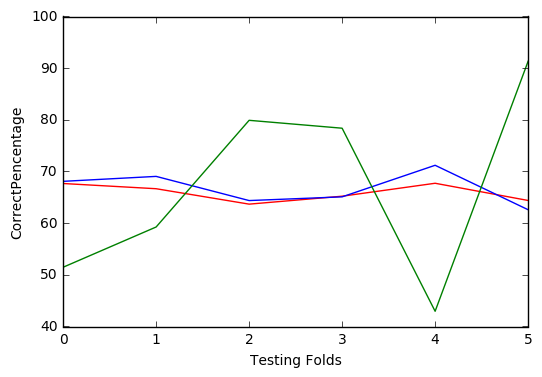

In [40]:
xaxis = range(len(results))
plt.plot(xaxis,results[:,1],'r-',label='TrnAcc')
plt.plot(xaxis,results[:,2],'b-',label='ValAcc')
plt.plot(xaxis,results[:,3],'g-',label='TesAcc')
plt.xlabel('Testing Folds')
plt.ylabel('CorrectPencentage')

In [20]:
lda = LDA()
lda.train(X,T)
print(lda.mu)

[array([[ 0.15998989],
       [-0.1218918 ],
       [-0.1218918 ],
       [ 0.01938066]]), array([[-0.51052953],
       [ 0.38895809],
       [ 0.38895809],
       [-0.06184391]])]


Apply Linear Regression:

In [80]:
resultsLr = ml.trainValidateTestKFoldsClassification( trainLr,evaluateLr, X,T, 
                                                     [None],nFolds=6, shuffle=False,verbose=False)
printResults('Lr:',resultsLr)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Algo           Parameters  TrnAcc  ValAcc  TesAcc
-------------------------------------------------
 Lr:                 None   68.11    0.00    0.00
 Lr:                 None   67.40    0.00    0.00
 Lr:                 None   61.65    0.00    0.00
 Lr:                 None   61.86    0.00    0.00
 Lr:                 None   66.67    0.00    0.00
 Lr:                 None   60.75    0.00    0.00


A interesting fact is that there are no values when testing the training model on the validate data and test data. No idea why did that happen.

Apply Non-Linear Regression:

In [57]:
resultsNN = ml.trainValidateTestKFoldsClassification( trainNN,evaluateNN, X,T, 
                                                     [ [ [0], 10], [[10], 100] ],
                                                     nFolds=6, shuffle=False,verbose=False)
printResults('NN:',resultsNN)


Algo           Parameters  TrnAcc  ValAcc  TesAcc
-------------------------------------------------
 NN:          [[10], 100]   68.40   65.87   76.35
 NN:          [[10], 100]   68.99   65.16   76.52
 NN:          [[10], 100]   70.45   66.42   70.59
 NN:          [[10], 100]   71.12   66.50   68.84
 NN:          [[10], 100]   71.54   68.36   61.24
 NN:          [[10], 100]   72.64   70.59   49.93


In [42]:
results = np.asarray(resultsNN)

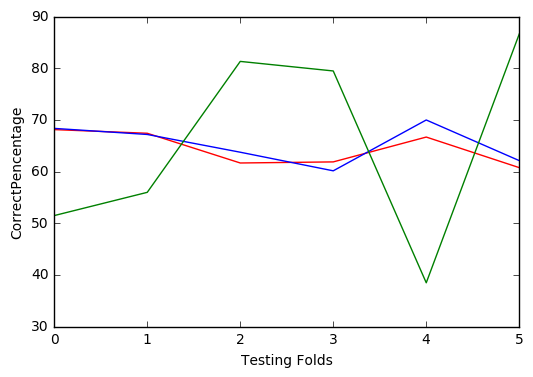

In [43]:
xaxis = range(len(results))
plt.plot(xaxis,results[:,1],'r-',label='TrnAcc')
plt.plot(xaxis,results[:,2],'b-',label='ValAcc')
plt.plot(xaxis,results[:,3],'g-',label='TesAcc')
plt.xlabel('Testing Folds')
plt.ylabel('CorrectPencentage')

### Abalone Data Set

The data I use is called Abalone Data Set. It was found from http://archive.ics.uci.edu/ml/datasets/Abalone and this dataset was taken from an original (non-machine-learning) study: 
Warwick J Nash, Tracy L Sellers, Simon R Talbot, Andrew J Cawthorn and Wes B Ford (1994) 
"The Population Biology of Abalone (_Haliotis_ species) in Tasmania. I. Blacklip Abalone (_H. rubra_) from the North Coast and Islands of Bass Strait", 
Sea Fisheries Division, Technical Report No. 48 (ISSN 1034-3288) 

And here are the meanings of each attribute below:

    Name		     Data Type	    Meas.	Description
    ----		     ---------	    -----	-----------
    Sex		         nominal			    M, F, and I (infant)
	Length		     continuous	   mm	 Longest shell measurement
	Diameter	     continuous	     mm	 perpendicular to length
	Height		     continuous	   mm	 with meat in shell
	Whole weight	 continuous       grams	whole abalone
	Shucked weight	 continuous	 grams	weight of meat
	Viscera weight	 continuous	 grams	gut weight (after bleeding)
	Shell weight	 continuous	   grams	after being dried
	Rings		     integer			     +1.5 gives the age in years


In [81]:
%precision 4

'%.4f'

In [89]:
data = []
f = open('abalone.data','r')

for k in range(4177):
    data.append(f.readline().rstrip().split(','))

# Here I need to change char to float(I-0,M-1,F-2), so that I can study them
for k in range(4177):
    if data[k][0] == 'M':
        data[k][0] = 1
    if data[k][0] == 'F':
        data[k][0] = 2
    if data[k][0] == 'I':
        data[k][0] = 0
data = [list(map(float, grp)) for grp in data]
data = np.asarray(data)
data.shape

(4177, 9)

In [90]:
X = data[:,1:]
T = data[:,0:1]
X.shape,T.shape

((4177, 8), (4177, 1))

In [91]:
Xname = ['Length','Diameter','Height','Whole weight','Shucked weight','Viscera weight','Shell weight','Rings']
Tname = ['Sex']

Apply LDA:

In [92]:
resultsLDA = ml.trainValidateTestKFoldsClassification( trainLDA,evaluateLDA, X,T, [None],
                                                       nFolds=6, shuffle=False,verbose=False)
printResults('LDA:',resultsLDA)


Algo           Parameters  TrnAcc  ValAcc  TesAcc
-------------------------------------------------
LDA:                 None   55.48   54.42   52.02
LDA:                 None   55.42   54.21   56.86
LDA:                 None   58.04   55.83   55.93
LDA:                 None   54.62   54.34   57.28
LDA:                 None   55.50   54.70   57.10
LDA:                 None   57.73   57.15   53.65


In [93]:
lda = LDA()
lda.train(X,T)
print(lda.mu)

[array([[-0.8015],
       [-0.8202],
       [-0.7537],
       [-0.8104],
       [-0.7585],
       [-0.8082],
       [-0.795 ],
       [-0.6338]]), array([[ 0.3115],
       [ 0.3165],
       [ 0.2837],
       [ 0.3319],
       [ 0.3315],
       [ 0.3189],
       [ 0.3099],
       [ 0.2394]]), array([[ 0.4589],
       [ 0.4722],
       [ 0.4422],
       [ 0.4442],
       [ 0.3912],
       [ 0.4571],
       [ 0.4539],
       [ 0.3709]])]


In [86]:
results = np.asarray(resultsLDA)

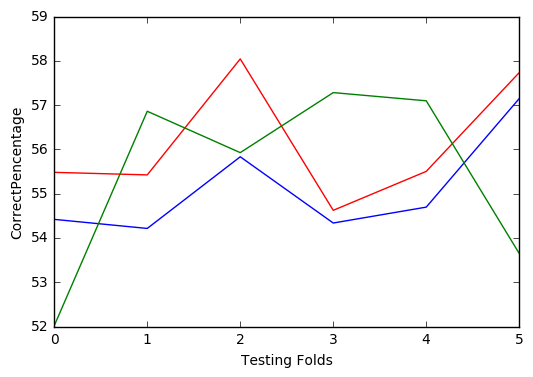

In [87]:
xaxis = range(len(results))
plt.plot(xaxis,results[:,1],'r-',label='TrnAcc')
plt.plot(xaxis,results[:,2],'b-',label='ValAcc')
plt.plot(xaxis,results[:,3],'g-',label='TesAcc')
plt.xlabel('Testing Folds')
plt.ylabel('CorrectPencentage')

Apply Linear Regression:

In [88]:
resultsLr = ml.trainValidateTestKFoldsClassification( trainLr,evaluateLr, X,T, 
                                                     [None],nFolds=6, shuffle=False,verbose=False)
printResults('Lr:',resultsLr)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Algo           Parameters  TrnAcc  ValAcc  TesAcc
-------------------------------------------------
 Lr:                 None   67.66    0.00    0.00
 Lr:                 None   67.78    0.00    0.00
 Lr:                 None   69.11    0.00    0.00
 Lr:                 None   69.52    0.00    0.00
 Lr:                 None   70.41    0.00    0.00
 Lr:                 None   71.39    0.00    0.00


Apply Non-Linear Regression:

In [51]:
resultsNN = ml.trainValidateTestKFoldsClassification( trainNN,evaluateNN, X,T, 
                                                     [ [ [0], 10], [[10], 100] ],
                                                     nFolds=6, shuffle=False,verbose=False)
printResults('NN:',resultsNN)


Algo           Parameters  TrnAcc  ValAcc  TesAcc
-------------------------------------------------
 NN:          [[10], 100]   68.56   65.54   75.78
 NN:          [[10], 100]   68.68   64.84   76.58
 NN:          [[10], 100]   70.44   66.74   70.30
 NN:          [[10], 100]   70.54   66.74   68.67
 NN:          [[10], 100]   71.76   68.34   61.57
 NN:          [[10], 100]   72.64   70.64   50.64


In [52]:
results = np.asarray(resultsNN)

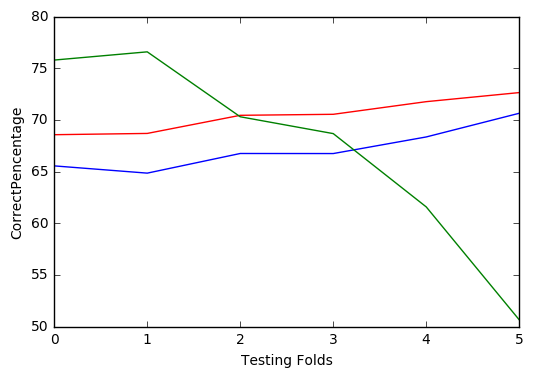

In [53]:
xaxis = range(len(results))
plt.plot(xaxis,results[:,1],'r-',label='TrnAcc')
plt.plot(xaxis,results[:,2],'b-',label='ValAcc')
plt.plot(xaxis,results[:,3],'g-',label='TesAcc')
plt.xlabel('Testing Folds')
plt.ylabel('CorrectPencentage')

## Results

According to the output, we can find the correct percentages of LDA, linear regression and non-linear regression are almost the same for the first data set. Even the trends are almost the same. However, for the second data set, it is obvious that the correct precentages of linear and non-linear regression are higher than LDA. Also, the trend of correct percentage of test set is keeping decreasing.

## Grading

Your notebook will be run and graded automatically. Download [A4grader.tar](http://www.cs.colostate.edu/~anderson/cs480/notebooks/A4grader.tar)  and extract A4grader.py from it. Run the code in the following cell to demonstrate an example grading session. You should see a perfect score of 80/100 if your functions are defined correctly. 

The remaining 20% will be based on your writing.  Be sure to explain each function, and details of the results summarized in the above section. 

In [94]:
%%writefile qdalda.py

import numpy as np
import sys # for sys.float_info.epsilon

######################################################################
### class QDA
######################################################################

class QDA(object):
    
    def __init__(self):
        # Define all instance variables here. Not necessary
        self.means = None
        self.stds = None
        self.mu = None
        self.sigma = None
        self.sigmaInv = None
        self.prior = None
        self.determinant = None
        self.discriminantConstant = None

    def train(self, X, T):
        self.classes = np.unique(T)
        self.means, self.stds = np.mean(X,0), np.std(X,0)
        Xs = (X - self.means) / self.stds
        self.mu = []
        self.sigma = []
        self.sigmaInv = []
        self.determinant = []
        self.prior = []
        nSamples = X.shape[0]
        for k in self.classes:
            rowsThisClass = (T == k).reshape((-1))
            self.mu.append( np.mean(Xs[rowsThisClass, :], 0).reshape((-1,1)) )
            self.sigma.append( np.cov(Xs[rowsThisClass, :], rowvar=0) )
            if self.sigma[-1].size == 1:
                self.sigma[-1] = self.sigma[-1].reshape((1,1))
            det = np.linalg.det(self.sigma[-1])
            if det == 0:
                det = sys.float_info.epsilon
            self.determinant.append( det )
            self.sigmaInv.append( np.linalg.pinv(self.sigma[-1]) )    # pinv in case Sigma is singular
            self.prior.append( np.sum(rowsThisClass) / float(nSamples) )
        self._finishTrain()

    def _finishTrain(self):
        self.discriminantConstant = []
        for ki in range(len(self.classes)):
            self.discriminantConstant.append( np.log(self.prior[ki]) - 0.5*np.log(self.determinant[ki]) )

    def use(self,X):
        nSamples = X.shape[0]
        Xs = (X - self.means) / self.stds
        discriminants,probabilities = self._discriminantFunction(Xs)
        predictedClass = self.classes[np.argmax( discriminants, axis=1 )]
        predictedClass = predictedClass.reshape((-1, 1))
        D = X.shape[1]
        return predictedClass, probabilities, discriminants

    def _discriminantFunction(self, Xs):
        nSamples = Xs.shape[0]
        discriminants = np.zeros((nSamples, len(self.classes)))
        for ki in range(len(self.classes)):
            Xc = Xs - self.mu[ki]
            discriminants[:,ki:ki+1] = self.discriminantConstant[ki] - 0.5 * \
                                       np.sum(np.dot(Xc, self.sigmaInv[ki]) * Xc, axis=1).reshape((-1,1))
        probabilities = np.exp( discriminants - 0.5*D*np.log(2*np.pi) )
        return discriminants, probabilities
        
    def __repr__(self):
        if self.mu is None:
            return 'QDA not trained.'
        else:
            return 'QDA trained for classes {}'.format(self.classes)

######################################################################
### class LDA
######################################################################

class LDA(QDA):

    def _finishTrain(self):
        self.sigmaMean = np.sum(np.stack(self.sigma) * np.array(self.prior)[:,np.newaxis,np.newaxis], axis=0)
        self.sigmaMeanInv = np.linalg.pinv(self.sigmaMean)
        # print(self.sigma)
        # print(self.sigmaMean)
        self.discriminantConstant = []
        self.discriminantCoefficient = []
        for ki in range(len(self.classes)):
            sigmaMu = np.dot(self.sigmaMeanInv, self.mu[ki])
            self.discriminantConstant.append( -0.5 * np.dot(self.mu[ki].T, sigmaMu) )
            self.discriminantCoefficient.append( sigmaMu )
    
    def _discriminantFunction(self,Xs):
        nSamples = Xs.shape[0]
        discriminants = np.zeros((nSamples, len(self.classes)))
        for ki in range(len(self.classes)):
            discriminants[:,ki:ki+1] = self.discriminantConstant[ki] + \
                                       np.dot(Xs, self.discriminantCoefficient[ki])
        probabilities = np.exp( discriminants - 0.5*D*np.log(2*np.pi) - 0.5*np.log(self.determinant[ki]) \
                               - 0.5*np.sum(np.dot(Xs,self.sigmaMeanInv) * Xs, axis=1).reshape((-1,1)))
        return discriminants, probabilities

######################################################################
### Example use
######################################################################

if __name__ == '__main__':

    D = 1  # number of components in each sample
    N = 10  # number of samples in each class
    X = np.vstack((np.random.normal(0.0, 1.0, (N, D)),
                   np.random.normal(4.0, 1.5, (N, D))))
    T = np.vstack((np.array([1]*N).reshape((N, 1)),
                   np.array([2]*N).reshape((N, 1))))

    qda = QDA()
    qda.train(X,T)
    c,prob,_ = qda.use(X)
    print('QDA', np.sum(c==T)/X.shape[0] * 100, '% correct')
    print('{:>3s} {:>4s} {:>14s}'.format('T','Pred','prob(C=k|x)'))
    for row in np.hstack((T,c,prob)):
        print('{:3.0f} {:3.0f} {:8.4f} {:8.4f}'.format(*row))

    lda = LDA()
    lda.train(X,T)
    c,prob,d = lda.use(X)
    print('LDA', np.sum(c==T)/X.shape[0] * 100, '% correct')
    print('{:>3s} {:>4s} {:>14s}'.format('T','Pred','prob(C=k|x)'))
    for row in np.hstack((T,c,prob)):
        print('{:3.0f} {:3.0f} {:8.4f} {:8.4f}'.format(*row))

Overwriting qdalda.py


In [95]:
%run -i A4grader.py


   Testing   model = trainLDA(X,T)
             accuracy = evaluateLDA(model,X,T)

20/20 points. Accuracy is within 10 of correct value 50%

   Testing   model = trainNN(X,T, [[5],100])
             accuracy = evaluateNN(model,X,T)

30/30 points. Accuracy is within 10 of correct value 100%

  Testing
    resultsNN = ml.trainValidateTestKFoldsClassification( trainNN,evaluateNN, X,T, 
                                                          [ [ [0], 5], [ [10], 100] ],
                                                          nFolds=3, shuffle=False,verbose=False)
    bestParms = [row[0] for row in resultsNN]


30/30 points. You correctly find the best parameters to be [[10],100] for each fold.

CS480 CODING GRADE is 80/80

CS480 WRITING GRADE is ??/20

CS480 FINAL GRADE is ??/100

Remember, this python script is just an example of how your code will be graded.
Do not be satisfied with an 80% from running this script.  Write and run additional
tests of your own design.
